In [1]:
from __future__ import print_function
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse

In [2]:
root = "./"
def default_loader(path):
    return Image.open(path).convert('RGB')

In [3]:
class MyDataset(torch.utils.data.Dataset): 
    def __init__(self,root, datatxt, transform=None, target_transform=None,loader=default_loader):
        super(MyDataset,self).__init__()
        fh = open(root + datatxt, 'r') 
        imgs = []     
        data = []
        label = []
        for line in fh:                
            line = line.rstrip()       
            data.append(line)
        for line in range(len(data)-1):
            words = data[line].split()  
            imgs.append((words[0])) 
            label.append(int(words[1]))
            
        
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.label = torch.LongTensor(label)
 
    # def __getitem__(self, index):    
    def __getitem__(self, idx):    
        image = Image.open(str(self.imgs[idx]))
        # image = image.convert('RGB')
        image = image.convert('L')
        if self.transform is not None:
            image = self.transform(image)
        label = self.label[idx]
        return image, label
    def __len__(self): 
        return len(self.imgs)

In [4]:
train_dataset = MyDataset(root='./',datatxt='train.txt',transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))
test_dataset = MyDataset(root='./',datatxt='test.txt', transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ]))
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True,num_workers=1)
print('num_of_trainData:', len(train_dataset))
print('num_of_testData:', len(test_dataset))

num_of_trainData: 7930
num_of_testData: 1958


label： tensor(0)


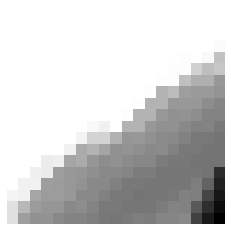

In [5]:
idx = 2
img = train_dataset[idx][0].numpy()
plt.imshow(img[0], cmap = 'gray')
plt.axis('off') 
print('label：',train_dataset[idx][1])
plt.show()

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        # self.fc1 = nn.Linear(9216, 128)
        self.fc1 = nn.Linear(3136, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/7930 (0%)]	Loss: 2.297469
Train Epoch: 1 [640/7930 (8%)]	Loss: 0.741425
Train Epoch: 1 [1280/7930 (16%)]	Loss: 0.499006
Train Epoch: 1 [1920/7930 (24%)]	Loss: 0.778936
Train Epoch: 1 [2560/7930 (32%)]	Loss: 0.529081
Train Epoch: 1 [3200/7930 (40%)]	Loss: 0.567623
Train Epoch: 1 [3840/7930 (48%)]	Loss: 0.617054
Train Epoch: 1 [4480/7930 (56%)]	Loss: 0.483812
Train Epoch: 1 [5120/7930 (65%)]	Loss: 0.474005
Train Epoch: 1 [5760/7930 (73%)]	Loss: 0.401480
Train Epoch: 1 [6400/7930 (81%)]	Loss: 0.445680


KeyboardInterrupt: 